# Call center data modeling

* Run the code below to get started. This is a partial solution to the pre-class work.
* Complete the tasks following the code.

## Loading the data

In [9]:
import numpy as np
import scipy as sp
import scipy.stats as sts
import matplotlib.pyplot as plt

%matplotlib inline

Size of data set: 5856
First 3 values in data set: [30.   3.4  3.2]
Sum of data set: 1441.6838153800093


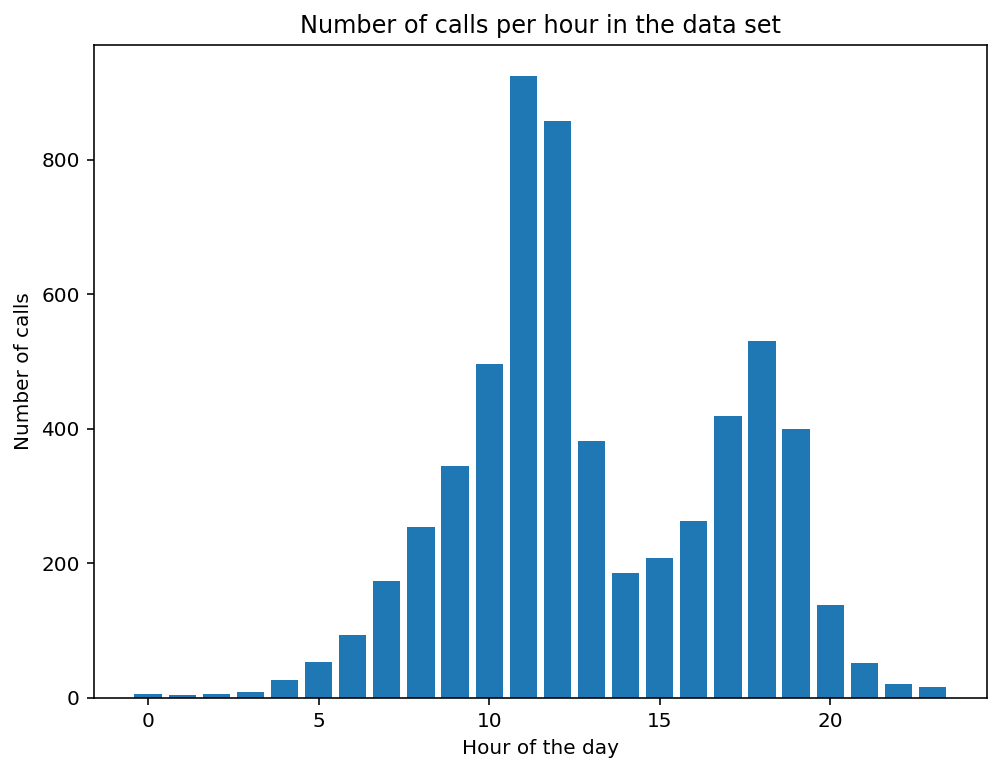

In [6]:
# Load the data set containing durations between calls arriving at the call
# center during 1 day. All values are in minutes.
waiting_times_day = np.loadtxt('call_center.csv')

# Display some basic information about the data set.
print('Size of data set:', len(waiting_times_day))
print('First 3 values in data set:', waiting_times_day[:3])
print('Sum of data set:', sum(waiting_times_day))

# Make 24 empty lists, one per hour.
waiting_times_per_hour = [[] for _ in range(24)]

# Split the data into 24 separate series, one for each hour of the day.
current_time = 0
for t in waiting_times_day:
    current_hour = int(current_time // 60)
    current_time += t
    waiting_times_per_hour[current_hour].append(t)

# Plot the number of calls per hour using a bar chart
plt.figure(figsize=(8, 6))
plt.bar(range(24), [len(w) for w in waiting_times_per_hour])
plt.xlabel('Hour of the day')
plt.ylabel('Number of calls')
plt.title('Number of calls per hour in the data set')
plt.show()

## Plot a histogram of the call wait times for hour 9

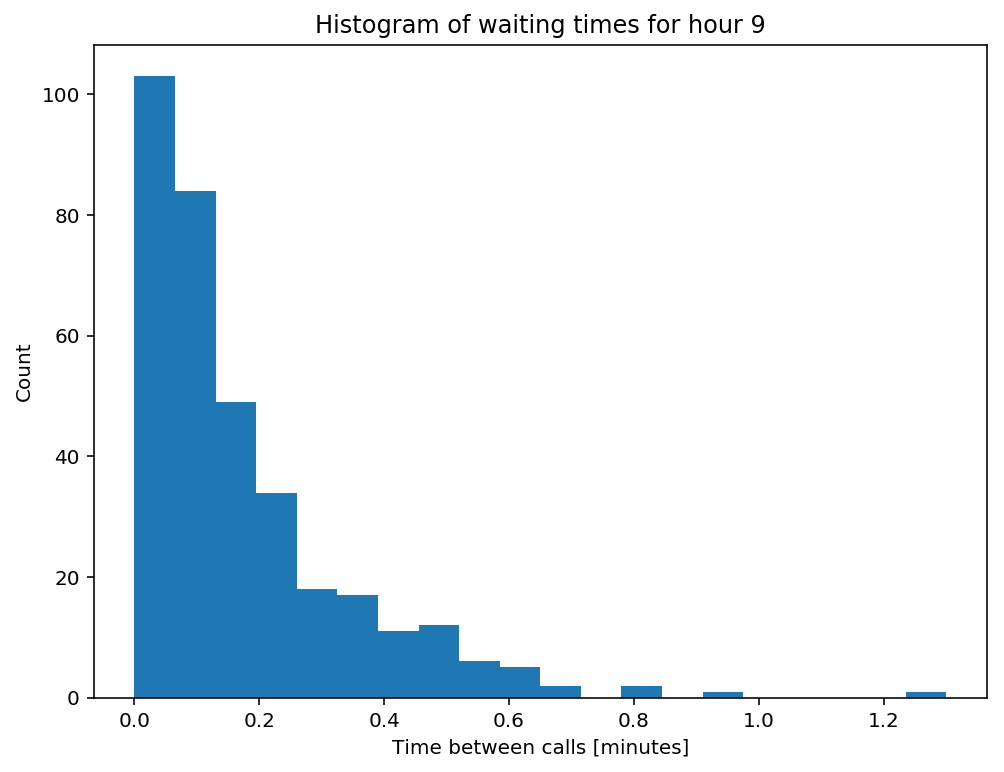

In [8]:
# Plot histogram of waiting times for one hour
hour_index = 9
waiting_times_hour = waiting_times_per_hour[hour_index]

plt.figure(figsize=(8, 6))
plt.hist(waiting_times_hour, bins=20)
plt.xlabel('Time between calls [minutes]')
plt.ylabel('Count')
plt.title(f'Histogram of waiting times for hour {hour_index}')
plt.show()

## Guess a plausible likelihood function

* The histogram above looks a lot like an instance of the exponential distribution.
* The exponential distribution has 1 parameter, namely the rate $\lambda.$
* A good initial guess for the rate (called the _maximum likelihood estimate_) is the average of the data.
* Note that the maximum likelihood estimate does not give us any information about how much uncertainty there is in our guess for $\lambda$. This is a common problem.

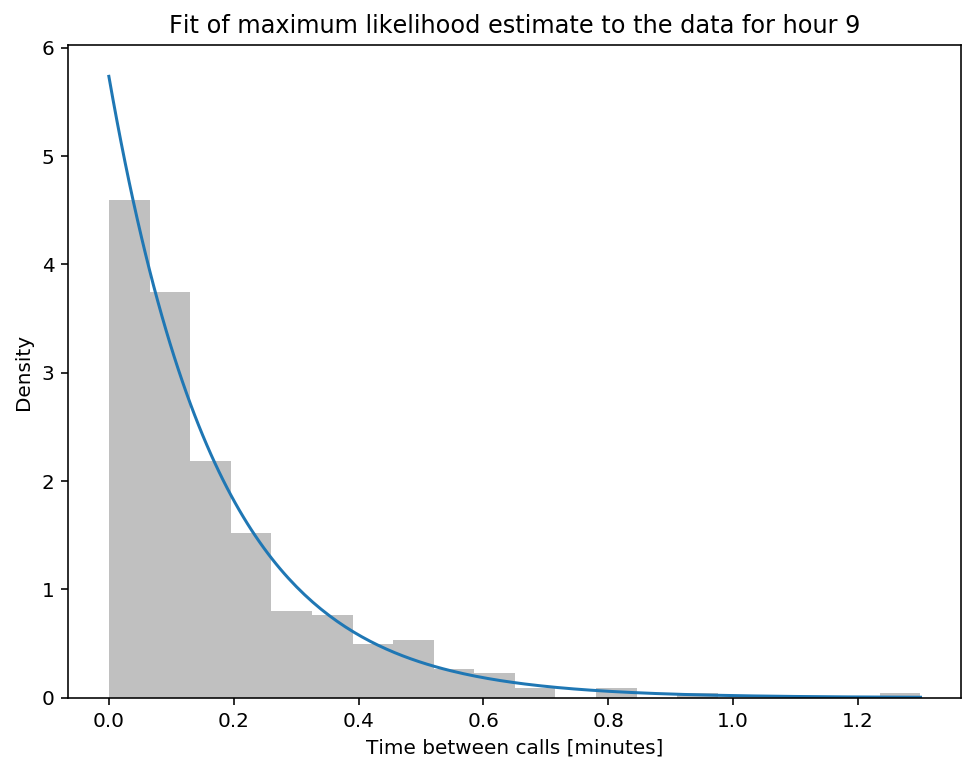

In [10]:
# Exponential distribution with maximum likelihood fit to the data
lambda_ = 1 / np.mean(waiting_times_hour)
distribution = sts.expon(scale=1/lambda_)

plt.figure(figsize=(8, 6))
plt.hist(waiting_times_hour, bins=20, density=True, color='#c0c0c0')
x = np.linspace(0, max(waiting_times_hour), 200)
y = distribution.pdf(x)
plt.plot(x, y)
plt.xlabel('Time between calls [minutes]')
plt.ylabel('Density')
plt.title(f'Fit of maximum likelihood estimate to the data for hour {hour_index}')
plt.show()

## Pause here

**Discuss the following in your group.**

1. Why does the exponential distribution fit the data histogram quite well in the plot above?

- It looks like it
- Lamda is 1/ average waiting time (expected value(average) of a exponential distribution is 1/lambda, so we can get lambda using the expected value)



2. Why is the vertical scale (0 to 6) different from the vertical scale in the previous histogram (0 to 100) even though it's a plot of the same data.
- You take the normalized density of the histogram instead of the counts.



## Task 1: Fit an exponential distribution to the data for hour 9

1. We do Bayesian inference on this problem
2. Use the **exponential distribution** as your **likelihood function**. You need to fill in the `likelihood` function below.
3. Use a **gamma distribution** with parameters $\alpha=1$ and $\beta=0.25$ as your **prior**. You need to fill in the `prior` function below.
4. **Compute the posterior distribution over $\lambda$.**
5. **Plot the prior and posterior** distributions on the same axes.

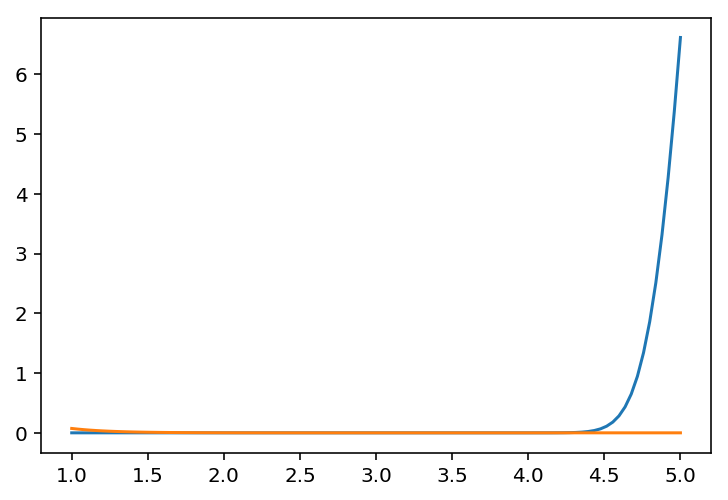

In [31]:
import numpy as np
import scipy.stats as sts
# THE LIKELIHOOD FUNCTION
#
# This function takes 2 inputs, namely the parameter (λ) value at which to
# compute the likelihood and a value from the data set. You need to evaluate
# the exponential distribution of the datum given the parameter value.

def likelihood(lambda_, datum):
#     lower_limit = 0
#     upper_limit = np.inf
#     likelihood = sts.expon.pdf(
#         datum,
#         (lower_limit-mu)/sigma,  # See the SciPy documentation. The lower and upper
#         (upper_limit-mu)/sigma,  # limits are defined in terms of the standard normal.
#         loc=mu,
#     scale=sigma)
    
    return sts.expon.pdf(datum, scale=1/lambda_)
#     plt.plot(datum, sts.expon.pdf)

# THE PRIOR DISTRIBUTION
#
# This function takes 1 input, namely the parameter value (λ) at which to
# compute the prior probability density. You need to evaluate the distribution
# Gamma(λ | α, β).

def prior(lambda_):
#     gamma(a=α, scale=1/β)
    alpha = 1 # alpha parameter
    beta = 4  # beta perimieter
    return sts.gamma(a=alpha, scale=1/beta).pdf(lambda_)
#     return ...  # YOU NEED TO COMPLETE THIS.

# THE POSTERIOR DISTRIBUTION
#
# The function below is provided to help make computing the posterior easier. It
# follows the same pattern as in the previous class, where we multiple the prior
# and the likelihood evaluated at various values of the parameter (λ).
#
# You will see the function uses the logarithms of various distributions. This
# is for numerical reasons. When you multiply lots of likelihood values, the
# result can become very large or very small, causing numerical overflow or
# underflow in Python. Taking logarithms avoids this problem.

def compute_posterior(parameter_values, prior, likelihood, data):
    log_prior = np.log(prior(parameter_values))
    log_likelihood = np.array([
        np.sum(np.log(likelihood(param, data)))
        for param in parameter_values])
    unnormalized_log_posterior = log_prior + log_likelihood
    unnormalized_log_posterior -= max(unnormalized_log_posterior)
    unnormalized_posterior = np.exp(unnormalized_log_posterior)
    area = sp.integrate.trapz(unnormalized_posterior, parameter_values)
    posterior = unnormalized_posterior / area
    return posterior

lambdas = np.linspace(1, 5, 100)  # YOU NEED TO COMPLETE THIS.
posterior = compute_posterior(lambdas, prior, likelihood, waiting_times_hour)

# YOU NEED TO PLOT THE PRIOR AND POSTERIOR ON THE SAME AXES.
plt.plot(lambdas, posterior)
plt.plot(lambdas, [prior(lambda_) for lambda_ in lambdas])
plt.show()

## Task 2: Summarize your results

1. **Compute a 98% confidence interval** over the posterior $\lambda$. Use the code provided below to help you.
2. **Discuss** the width of the confidence interval. How certain are we about the call rate during this hour of the day?


In [32]:
def compute_percentile(parameter_values, distribution_values, percentile):
    '''
    Compute the parameter value at a particular percentile of the given
    probability distribution values. This function uses the cumulative trapezoid
    integrator in SciPy.

    Inputs:

        parameter_values (array of float) This is the list of parameter values
          at which the probability distribution has been evaluated.

        distribution_values (array of float) This is the list of values of the
          probability density function evaluated at the parameter values above.

        percentile (float) This is the value between 0 and 1 of the percentile
          to compute.

    Returns: (float) The parameter value at the given percentile.
    '''
    cumulative_distribution = sp.integrate.cumtrapz(
        distribution_values, parameter_values)
    percentile_index = np.searchsorted(cumulative_distribution, percentile)
    return lambdas[percentile_index]

# YOU HAVE TO USE THE FUNCTION ABOVE TO COMPUTE THE CONFIDENCE INTERVAL

print(compute_percentile(lambdas, posterior, 0.01), compute_percentile(lambdas, posterior, 0.01))

4.515151515151516